Pokemon dataset was taken from the pokemon image dataset on [Kaggle](https://www.kaggle.com/datasets/lantian773030/pokemonclassification). All pokemon is used compared to the previous models where it was only the four starter pokemons. Animal dataset was taken from the animal image dataset on [Kaggle](https://www.kaggle.com/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals). Both were combined and formed to create a binary classification model that can differentiate between a real life animal and a pokemon.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, Dropout, Flatten, GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
import os
import shutil
import splitfolders
import random
import imghdr
import cv2
import itertools
from sklearn.metrics import confusion_matrix, accuracy_score

As the images are all in subdirectories of each folder, I will use the created function below to move the images in the subfolders into a new folder depending on if it is an animal or pokemon.

In [62]:
animal_data_dir = 'C:/Users/John/Documents/ml_projects/pokemon-classifier/data/animals'
pokemon_data_dir = 'C:/Users/John/Documents/ml_projects/pokemon-classifier/data/all_pokemon'
new_animal_dir = 'C:/Users/John/Documents/ml_projects/pokemon-classifier/data/all_images/all_animals'
new_pokemon_dir = 'C:/Users/John/Documents/ml_projects/pokemon-classifier/data/all_images/all_pokemon'

def copy_files(initial_directory, final_directory, subfolder = True):
    """
    Takes in two folder locations where it will transfer the items in the subfolders of initial_directory 
    to the final directory folder. If subfolder is False, it will transfer the items in the initial directory 
    to the new folder directory

    
    Parameters:
        initial_directory: folder with subfolders of images
        final_directory: folder where all images will be copied to
    
    Returns:
        A folder which has all images from the initial_directory copied into it

    """
    if subfolder == True:
        for item in os.listdir(initial_directory):
            for image in os.listdir(os.path.join(initial_directory, item)):
                image_path = os.path.join(initial_directory, item, image)
                shutil.copy(image_path, final_directory)
    elif subfolder == False:
        for item in os.listdir(initial_directory):
            image_path = os.path.join(initial_directory, item)
            shutil.copy(image_path, final_directory)

In [ ]:
copy_files(animal_data_dir, new_animal_dir)
copy_files(pokemon_data_dir, new_pokemon_dir)

I will check for any corrupted images and remove them before spliting them into a train, test and validation set. After validating all the images, I will check the number of images for both animal and pokemon to ensure there is no sampling bias. 

In [204]:
def image_integrity(initial_directory):
    """ 
    Takes an initial directory where the root folder of all images in the subfolder are located 
    and checks if all images can be opened
    
    Parameters: 
        initial_directory: root folder of all images in a subfolder
    
    Returns:
        The same folder which has all un-readable images removed.
    """
    image_exts = ['jpeg', 'jpg', 'bmp', 'png']
    for folder in os.listdir(initial_directory):
        for image in os.listdir(os.path.join(initial_directory, folder)):
            image_path = os.path.join(initial_directory, folder, image)
            try:
                image = cv2.imread(image_path)
                tip = imghdr.what(image_path)
                if tip not in image_exts:
                    os.remove(image_path)
            except Exception as e:
                print(f'Image Issue {image_path}')
        print(f'Number of files for {folder}:', len(os.listdir(os.path.join(initial_directory, folder))))

In [205]:
all_image_dir = 'C:/Users/John/Documents/ml_projects/pokemon-classifier/data/all_images'
image_integrity(all_image_dir)

Number of files for all_animals: 5399
Number of files for all_pokemon: 6724


In [206]:
num_animal_images = len(os.listdir(new_animal_dir))
num_pokemon_images = len(os.listdir(new_pokemon_dir))
print('number of animal images: ', num_animal_images)
print('number of pokemon images: ', num_pokemon_images)
total_images = num_animal_images + num_pokemon_images
print('total images: ', total_images)
print('fraction of animal to pokemon images: ', num_animal_images/total_images)

number of animal images:  5399
number of pokemon images:  6724
total images:  12123
fraction of animal to pokemon images:  0.44535181060793533


As there more pokemon images, I will use undersampling and randomly choose 5399 images of pokemon to balance the dataset. I will repeat the process above and move the selected images to a new folder where the train,test,validation split will occur.

In [172]:
np.random.seed(seed=10)
selected_pokemon = np.random.permutation(os.listdir(new_pokemon_dir))[:5399].tolist()
selected_pokemon_list = [os.path.join(new_pokemon_dir, image) for image in selected_pokemon]

In [168]:
def same_name_copy(initial_file_name, final_file_name):
    """
    Checks to see if the initial file name has a copy already in the folder it is being moved into.

    Parameters:
        initial_file_name: the name of the initial file
        final_file_name: the name of the folder the file is being moved into
    
    Returns:
        Changes the name of the file if its name is already taken and copies it into the final folder.
    """
    name = os.path.basename(initial_file_name)
    if not os.path.exists(os.path.join(final_file_name, name)):
        shutil.copy(initial_file_name, os.path.join(final_file_name, name))
    else:
        root, extension = os.path.splitext(name)
        i = 1
        while os.path.exists(os.path.join(final_file_name, f'{root}_{i}{extension}')):
            i += 1
        shutil.copy(initial_file_name, os.path.join(final_file_name, f'{root}_{i}{extension}'))


In [ ]:
final_pokemon_dir = 'C:/Users/John/Documents/ml_projects/pokemon-classifier/data/train_test_val/pokemon'
final_animal_dir = 'C:/Users/John/Documents/ml_projects/pokemon-classifier/data/train_test_val/animal'

copy_files(new_animal_dir, final_animal_dir, subfolder=False)
for image in selected_pokemon_list:
    same_name_copy(image, final_pokemon_dir)

In [176]:
print('number of animal images: ', len(os.listdir(final_animal_dir)))
print('number of pokemon images: ', len(os.listdir(final_pokemon_dir)))

number of animal images:  5399
number of pokemon images:  5399


Now it is time to split up the dataset into a train, validation and test set

In [247]:
all_images = 'C:/Users/John/Documents/ml_projects/pokemon-classifier/data/train_test_val'
splitfolders.ratio(all_images, output = 'output_folder', seed = 1, ratio=(0.8,0.1,0.1))

Copying files: 10798 files [00:16, 657.54 files/s]


Now that the folder is created, I will move it back into the data folder to tidy up the repository. 

In [2]:
train = ImageDataGenerator(rescale=1/255.0)
validation = ImageDataGenerator(rescale=1/255.0)

train_ds = train.flow_from_directory('C:/Users/John/Documents/ml_projects/pokemon-classifier/data/output_folder/train',
                                     color_mode = 'rgb',
                                     batch_size=32,
                                     target_size=(224, 224),
                                     shuffle=True,
                                     seed=1)

val_ds = validation.flow_from_directory('C:/Users/John/Documents/ml_projects/pokemon-classifier/data/output_folder/val',
                                        color_mode = 'rgb',
                                        batch_size=32,
                                        target_size=(224, 224),
                                        shuffle=True,
                                        seed=1)

Found 8628 images belonging to 2 classes.
Found 1078 images belonging to 2 classes.


In [3]:
feature_extractor = VGG16(weights = 'imagenet', input_shape=(224,224,3), include_top=False)
feature_extractor.trainable = False

In [4]:
input = Input(shape = (224,224,3))
x = feature_extractor(input, training = False)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(32, activation = 'relu')(x)
x = Dropout(0.2)(x)
output = Dense(2, activation = 'softmax')(x)
model = Model(input, output)
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 32)                802848    
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 66    

In [5]:
model_fit = model.fit(train_ds, epochs=20, validation_data = val_ds)

Epoch 1/20
270/270 [==============================] - 560s 2s/step - loss: 0.2448 - accuracy: 0.9375 - val_loss: 0.0839 - val_accuracy: 0.9731
Epoch 2/20
270/270 [==============================] - 541s 2s/step - loss: 0.1193 - accuracy: 0.9672 - val_loss: 0.0693 - val_accuracy: 0.9750
Epoch 3/20
270/270 [==============================] - 536s 2s/step - loss: 0.0691 - accuracy: 0.9801 - val_loss: 0.0497 - val_accuracy: 0.9842
Epoch 4/20
270/270 [==============================] - 536s 2s/step - loss: 0.0450 - accuracy: 0.9870 - val_loss: 0.0464 - val_accuracy: 0.9824
Epoch 5/20
270/270 [==============================] - 554s 2s/step - loss: 0.0310 - accuracy: 0.9917 - val_loss: 0.0612 - val_accuracy: 0.9787
Epoch 6/20
270/270 [==============================] - 618s 2s/step - loss: 0.0296 - accuracy: 0.9903 - val_loss: 0.0422 - val_accuracy: 0.9833
Epoch 7/20
270/270 [==============================] - 546s 2s/step - loss: 0.0289 - accuracy: 0.9901 - val_loss: 0.1221 - val_accuracy: 0.9759

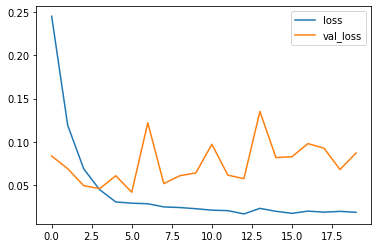

In [6]:
plt.plot(model_fit.history['loss'], label='loss')
plt.plot(model_fit.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

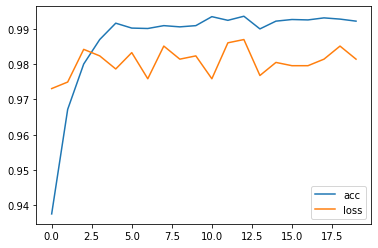

In [7]:
plt.plot(model_fit.history['accuracy'], label='acc')
plt.plot(model_fit.history['val_accuracy'], label='loss')
plt.legend()
plt.show()

In [10]:
test_dir = 'C:/Users/John/Documents/ml_projects/pokemon-classifier/data/output_folder/test'
true_list = []
prediction_list = []
incorrect_list = []
for folder in os.listdir(test_dir):
    for image_name in os.listdir(os.path.join(test_dir, folder)):
        try:
            image_file = tf.keras.preprocessing.image.load_img(os.path.join(test_dir, folder, image_name), target_size = (224,224))
            true_list.append(folder)

            X = tf.keras.preprocessing.image.img_to_array(image_file)
            X = np.expand_dims(X, axis=0)
            predictions = model.predict(X).argmax(1)
            prediction_list.append(predictions)
        except Exception as e:
            print(f'error at: {test_dir}{folder}{image_name}')
    
    for i in range(len(true_list)):
        if true_list[i] == 'animal':
            true_list[i] = 0
        if true_list[i] == 'pokemon':
            true_list[i] = 1


1/1 [==============================] - 0s 106ms/step
error at: C:/Users/John/Documents/ml_projects/pokemon-classifier/data/output_folder/testpokemonbb5d47bced6e4e33a77faa17e1eec906.svg
1/1 [==============================] - 0s 116ms/step
error at: C:/Users/John/Documents/ml_projects/pokemon-classifier/data/output_folder/testpokemonc99b2d19544c4cbbacd7711ade660279.svg
1/1 [==============================] - 0s 109ms/step


There were some images that were hidden and not caught in the above initial screening, so I utilized a try, except cause to bypass images that are corrupt and unable to be read into the model. From here, I will look at a confusion matrix and its overall accuracy.

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion matrix, without normalization
[[535   6]
 [  6 533]]


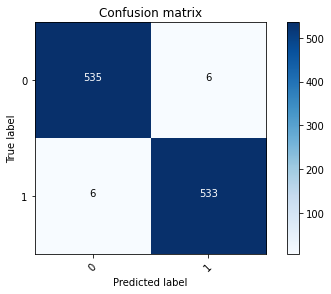

In [12]:
cm = confusion_matrix(true_list, prediction_list)
plot_confusion_matrix(cm, list(range(2)))

In [13]:
score = accuracy_score(true_list, prediction_list)
print('accuracy score: ', score)

accuracy score:  0.9888888888888889


In the end, it looks like the transfer learning of the model did a very good job in accurately predicting if an image is a pokemon or an animal with an accuracy score of almost 99%!